## Environment Setup
For Colab, the helper folders need to be copied over from the repo. The below cell does this automatically.

In [1]:
%%bash

# Check if the environment variable exists
if [ -n "$COLAB_RELEASE_TAG" ] || [ -n "$COLAB_GPU" ]; then
    echo "Running on Google Colab. Cloning repository into temp folder..."
    git clone https://github.com/TuebingenAICenter/agent-tutorial.git /tmp/tmp_repo
    echo "Moving all helpers to project root..."
    mv /tmp/tmp_repo/chat_with_X_utils .
    mv /tmp/tmp_repo/images .
    mv /tmp/tmp_repo/env.example ./.env
    mv /tmp/tmp_repo/requirements.txt .
else
    echo "Not running on Google Colab. Skipping git clone."
fi

# The installation block runs regardless of environment.
echo "Checking for requirements.txt and installing required packages..."

# Check if requirements.txt exists in the current directory
if [ -f "requirements.txt" ]; then
    # Attempt to install with 'uv', and if it fails (exit code != 0), use 'pip' as a fallback.
    if command -v uv &> /dev/null; then
        echo "uv detected. Installing with uv..."
        uv pip install -r requirements.txt
    else
        echo "Installing with pip..."
        pip install -r requirements.txt
    fi
else
    echo "ERROR! requirements.txt not found! Please check for errors..."
fi

Not running on Google Colab. Skipping git clone.
Checking for requirements.txt and installing required packages...
uv detected. Installing with uv...


Using Python 3.12.2 environment at: /home/linus/miniconda3
Resolved 217 packages in 338ms
Audited 217 packages in 0.06ms


### Setting API key
The following cell sets the API key for accessing LLMs. The prompt will ask for `OPENROUTER_API_KEY` if it has not been set in the .env file.

Optionally an OpenAI key can be set in the `.env` file.

In [2]:
import dotenv
import os
from getpass import getpass

# Load environment variables from a .env file if it exists
dotenv.load_dotenv()
  
# Prompt for the API key if it's not already set
if not os.getenv("OPENROUTER_API_KEY"):
    os.environ["OPENROUTER_API_KEY"] = getpass(
        "Enter your OPENROUTER API key: "
    )
            
if not os.environ["OPENROUTER_API_KEY"]:
    print("WARNING: API key not set. Please run this cell again!")

# Example 02: RAG-based YouTube/PDF Chat

Now we know how a basic LangGraph system is implemented. Let's upgrade our tools towards a more useful application that let's us chat with an LLM about any PDF document or YouTube video.

**What:** chatbot using more complex tools, some of which will require human oversight to use.

**Why:** cement advanced concepts via implementation.

**Live:** we provide a notebook called `..._scaffolded.ipynb` that has some crucial lines of code missing. Follow along and see if you can fill in those lines to get the example working.

## What we plan to create

<img src="./images/Agent_02_diagram.png">

## What it looks like in LangGraph

<img src="./images/Agent_02_conditional_edges_colored_in.png">

## Setup

### Imports

In [3]:
# Core imports
import os
from typing import TypedDict, Annotated, List, Dict, Optional, Literal
from datetime import datetime

from chromadb.utils import embedding_functions
# LangGraph imports
from langgraph.graph import StateGraph, END, START
from langgraph.types import Command
from langgraph.prebuilt import ToolNode, tools_condition, InjectedState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

# LangChain imports
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import (
    HumanMessage, AIMessage, SystemMessage, BaseMessage, ToolMessage,
)

# Local utils (explicit imports)
from chat_with_X_utils.metadata_mangement import load_metadata
from chat_with_X_utils.tool_utils import (
    get_documents,
    embed_documents,
    parse_retrieval,
    create_selection_summary,
    get_database_info,
)
from chat_with_X_utils.print_utils import (
    print_messages_from_stream_event as _print_messages_from_stream_event,
    print_messages_from_state as _print_messages_from_state,
)


### Vector DB Setup

In [4]:
# Config
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200
EMBEDDINGS_MODEL = "text-embedding-3-small"
VECTOR_DB_PATH = "./chroma_db"
METADATA_FILE = "./document_metadata.json"

# Initialize components (single LLM)
if os.getenv("OPENAI_API_KEY"):
    llm = ChatOpenAI(
        model="gpt-4.1-mini-2025-04-14",
        temperature=0.0,
        openai_api_key=os.environ["OPENAI_API_KEY"],
    )
    embeddings = OpenAIEmbeddings(
        model=EMBEDDINGS_MODEL, 
        openai_api_key=os.environ["OPENAI_API_KEY"],
    )
else:
    llm = ChatOpenAI(
        model="gpt-4.1-mini-2025-04-14",
        temperature=0.0,
        base_url="https://openrouter.ai/api/v1",
        api_key=os.environ["OPENROUTER_API_KEY"],
    )
    from langchain_huggingface import HuggingFaceEmbeddings
    # Use a local model for embeddings 
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    separators=["\n\n", "\n", ". ", " ", ""]
)

# Initialize or load vector store
vector_store = Chroma(
    persist_directory=VECTOR_DB_PATH,
    collection_name="rag_documents",
    embedding_function=embeddings,
)

/home/linus/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chat with PDFs and YouTube videos (How to use tools)

The following cells contain some missing code for you to complete. Places where you need to fill in the missing code are marked by comments like:

```# TODO: Do XYZ```

### [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

Remember that the State ( an instance of `TypedDict`) is the main object that all nodes operate on & communicate with. In our current design, that state is defined to have the following keys:

- `messages` stores all messages to and from our LLM. *Notice:* we need a reducer function to integrate the update to the state sent by nodes.

- `documents_to_chat`: stores the document we want to chat with. 

In [5]:
from langgraph.graph import StateGraph

class RAGState(TypedDict):
    """Main state for the RAG system"""
    messages: Annotated[List[BaseMessage], add_messages]
    documents_to_chat: List[str]  # Selected document keys (doc_keys)

# TODO: Build the graph for this state. 
design_graph = StateGraph(RAGState)

### Tools

#### Tool 1: embed YouTube-transcript or PDF

We add chunks of YouTube-transcripts or PDF documents in our vector database for later retrieval by providing:

- a file path or URL for a PDF, or
- a URL of a YouTube video for videos.

In [ ]:
@tool(parse_docstring=True)
def embed_document(source: str, doc_type: Literal["youtube", "pdf"]) -> str:
    """Embed (or update) a YouTube video or PDF into the vector store.

    Uses deterministic per-chunk IDs derived from a document key so re-embedding
    replaces the prior version cleanly. Applies an atomic metadata update to
    avoid lost updates when multiple embeddings run concurrently.

    Args:
        source: For PDFs a local file path or HTTP(S) URL. For YouTube a full video URL.
        doc_type: The type of document to embed. Must be either "youtube" or "pdf".

    Returns:
        A human-readable summary including document key and number of chunks embedded.
    """
    try:
        # Build documents & add to vector store first (idempotent aside from deletes)
        metadata_snapshot = load_metadata(METADATA_FILE)
        doc_info = get_documents(source, doc_type)
        doc_info, chunks = embed_documents(doc_info, text_splitter, vector_store, metadata_snapshot, doc_type)
        (_, title, uploader, doc_key) = doc_info

        from chat_with_X_utils.metadata_mangement import atomic_update_metadata

        def _apply(current_meta):
            current_meta = dict(current_meta)
            current_meta[doc_key] = {
                'title': title,
                'type': doc_type,
                'source': source,
                'embedded_at': datetime.now().isoformat(),
                'num_chunks': len(chunks)
            }
            if doc_type == 'youtube':
                current_meta[doc_key]['uploader'] = uploader
            return current_meta, current_meta[doc_key]

        atomic_update_metadata(METADATA_FILE, _apply)
        return f"Embedded/Updated {doc_type}: '{title}' ({len(chunks)} chunks) key={doc_key}"

    except Exception as e:
        return f"Error embedding document: {str(e)}"


#### Tool 2: list documents available in database

Here we list which documents are currently available from our vector database by retrieving the information from our metadata file.

In [7]:
@tool(parse_docstring=True)
def list_documents() -> str:
    """List stored documents (sorted by title) with basic stats.

    Returns:
        Multi-line string enumerating each document, its key, chunk count and date.
    """
    metadata = load_metadata(METADATA_FILE)
    if not metadata:
        return "No documents in the database."
    return get_database_info(metadata) 


#### Tool 3: select which available document we want to chat with. 

For this we need to alter the graphs state from within the tool using the [Command](https://langchain-ai.github.io/langgraph/concepts/low_level/#command) object. 


- Because of the Message API we also need to append a ToolMessage with the correct ToolCallID to the `messages` key in the state. 

- For this we need to inject the `ToolCallId` tool call using [`InjectedToolCallId`](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolCallId.html). Note that this usually gets handled automatically when returning a regular String/ToolMessage from the tool.

In [8]:
from langgraph.types import Command
from langchain_core.tools import InjectedToolCallId
from langchain_core.messages import ToolMessage

@tool(parse_docstring=True)
def select_documents_for_chat(
    doc_keys: List[str],
    # TODO: Inject the tool call ID so you can attach a ToolMessage with the right ID
    tool_call_id: Annotated[str, InjectedToolCallId] = "",
):
    """Select documents (by key) to constrain subsequent retrieval.

    Args:
        doc_keys: List of document keys to select.
        tool_call_id: (Injected) Tool call ID used to attach a ToolMessage.

    Returns:
        Command updating state.documents_to_chat plus a summary ToolMessage.
    """
    metadata = load_metadata(METADATA_FILE)
    summary, valid_documents = create_selection_summary(metadata, doc_keys)
    # TODO: Return a Command that updates documents_to_chat and appends a ToolMessage with the summary and correct tool_call_id
    return Command(update={
        "documents_to_chat": valid_documents,
        "messages": [ToolMessage(summary, tool_call_id=tool_call_id)],
    })

#### Tool 4: retrieve embedded document chunks

- We want to limit the retrieval to specific documents, so we need to pass the corresponding value of the `documents_to_chat_with` key directly into the tool call using [`InjectedSate`](https://langchain-ai.github.io/langgraph/reference/agents/?h=injectedstate#langgraph.prebuilt.tool_node.InjectedState).

- This bypasses the possibility for the LLM-agent to make an error here.

In [9]:
from langgraph.prebuilt import InjectedState

@tool(parse_docstring=True)
def retrieve_chunks(
    query: str,
    # TODO: Inject the select documents (documents_to_chat) from the state directly.
    selected_documents: Annotated[List[str], InjectedState("documents_to_chat")] = [],
    k: int = 5,
) -> str:
    """Retrieve top-k chunks relevant to query over selected documents.

    Args:
        query: Natural language query to search for.
        selected_documents: (Injected) List of doc_keys currently selected; empty means search all.
        k: Number of chunks to return (default 5).

    Returns:
        Formatted string with retrieved chunk excerpts and source citations.
    """
    try:
        filter_dict = {"doc_key": {"$in": selected_documents}} if selected_documents else None
        results = vector_store.similarity_search(query=query, k=k, filter=filter_dict)
    
        if not results:
            return "No relevant chunks found."
    
        return parse_retrieval(results) 
    
    except Exception as e:
        return f"Error retrieving chunks: {str(e)}"


#### Tool 5: delete documents

Let's now combine everything we've learned about handling the graph state using injections and the Command object, by writing a tool to

- delete documents from our vector store and metadata file

- while automatically deselecting them from the `documents_to_chat` key in our state.

In [10]:
from langgraph.prebuilt import InjectedState
from langchain_core.tools import InjectedToolCallId
from langgraph.types import Command
from langchain_core.messages import ToolMessage

@tool(parse_docstring=True)
def delete_documents(
    doc_keys: List[str],
    # TODO: Inject the current selection (documents_to_chat) from the state directly.
    current_selection: Annotated[List[str], InjectedState("documents_to_chat")] = [],
    # TODO: Inject the tool call ID so you can attach a ToolMessage with the right ID
    tool_call_id: Annotated[str, InjectedToolCallId] = "",
):
    """Delete one or more documents and prune them from current selection atomically.

    Args:
        doc_keys: List of document keys to delete (supports multiple at once).
        current_selection: (Injected) Current selected doc keys from state.documents_to_chat.
        tool_call_id: (Injected) Tool call ID used to attach a ToolMessage.

    Returns:
        Command that updates documents_to_chat and appends a deletion summary ToolMessage.
    """
    try:
        from chat_with_X_utils.metadata_mangement import atomic_update_metadata, load_metadata
        from chat_with_X_utils.tool_utils import delete_documents_from_store, create_deletion_summary

        # Perform metadata mutation under atomic lock so parallel deletions don't race.
        def _apply(current_meta):
            # delete_documents_from_store mutates metadata in-place and returns summary info
            info = delete_documents_from_store(current_meta, doc_keys, vector_store)
            return current_meta, info  # updated dict + info tuple

        info = atomic_update_metadata(METADATA_FILE, _apply)
        # info = (not_found, deleted_keys, deleted_title_pairs)
        summary, updated_selection = create_deletion_summary(info, current_selection)

        # TODO: Return a Command that updates documents_to_chat and appends a ToolMessage with the summary and correct tool_call_id
        return Command(update={
            "documents_to_chat": updated_selection,
            "messages": [ToolMessage(summary, tool_call_id=tool_call_id)],
        })
    except Exception as e:
        return f"Error deleting document(s): {str(e)}"


### Nodes: Chat-LLM + tools

- **Before:** we only use one LLM-based node as our assistant. 

- **Now:** we put the `delete_documents` tool into a separate node $\rightarrow$ we want to interrupt the graph's execution and wait for user confirmation as a guard-rail against LLM-induced errors.

In [11]:
# Configuration for chat node (moved out of the node function)
TOOLS_ALL = [
    embed_document,
    list_documents,
    select_documents_for_chat,
    retrieve_chunks,
    delete_documents,
]

# TODO: Define SAFE_TOOLS and SENSITIVE_TOOLS appropriately.
SAFE_TOOLS = [embed_document, list_documents, select_documents_for_chat, retrieve_chunks]
SENSITIVE_TOOLS = [delete_documents]

SYSTEM_PROMPT = (
    "You are a helpful RAG assistant. Use tools for document management and retrieval. "
    "Always call retrieve_chunks(query=..., k=...) before giving a substantive answer that relies on document content. "
    "Cite timestamps for YouTube (mm:ss) and page numbers for PDFs when possible. "
    "If information isn't found, say so explicitly."
)

llm_with_tools = llm.bind_tools(TOOLS_ALL)

WELCOME_MESSAGE = (
    "Welcome to the RAG System! I can help you:\n\n"
    "📚 Document Management:\n"
    "- Embed (or update) YouTube videos or PDFs\n"
    "- List stored documents (shows each document key)\n"
    "- Delete documents by key (will ask for confirmation)\n\n"
    "💬 Chat & Retrieval:\n"
    "- Ask questions about your selected documents\n"
    "- Retrieve supporting chunks with sources (timestamps/pages)\n\n"
    "Just tell me what you'd like to do!"
)

In [12]:
def chat_node(state: RAGState) -> Dict:
    messages = state.get("messages", [])
    current_selection = state.get("documents_to_chat", [])

    # First turn: emit a welcome AIMessage without invoking the LLM 
    if not messages:
        return {
            "messages": [AIMessage(content=WELCOME_MESSAGE)],
            "documents_to_chat": current_selection
        }

    # Invoke the already tool-bound model with a prepended system message
    response = llm_with_tools.invoke([
        SystemMessage(content=SYSTEM_PROMPT),
        *messages
    ])

    return {"messages": [response]}

design_graph.add_node("chat", chat_node)

In [13]:
# Nodes containing tool execution logic (referencing pre-defined tool groups)
design_graph.add_node("safe_tools", ToolNode(SAFE_TOOLS))
design_graph.add_node("sensitive_tools", ToolNode(SENSITIVE_TOOLS))

### Edges
- **Before** our routing funciton router either to the "multiply_tool" node if a tool call was present or END if there wasn't.

- **Now** we want to route based on the safety of a tool. We write a custom [conditional edge](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges), which returns the name of the correct ToolNode to route to or END.

In [14]:
def route_tools(state: RAGState):
    nxt = tools_condition(state)
    if nxt == END:
        return END
    ai_msg = state["messages"][-1]
    tool_calls = getattr(ai_msg, "tool_calls", [])
    if any(tc.get("name") == "delete_documents" for tc in tool_calls):
        return "sensitive_tools"
    return "safe_tools"

design_graph.add_edge(START, "chat")
# TODO: Add conditional edges from chat to the tool nodes using route_tools
design_graph.add_conditional_edges("chat", route_tools, ["safe_tools", "sensitive_tools", END])
design_graph.add_edge("safe_tools", "chat")
design_graph.add_edge("sensitive_tools", "chat")

### Compile and Test

- We only want to user sensitive tools with after getting a user confirmation (*human-in-the-loop*). 

- So, we use the `interrupt_before` argument in the [compile](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.compile) function, that specifies the node before with the interrupt occurs. 

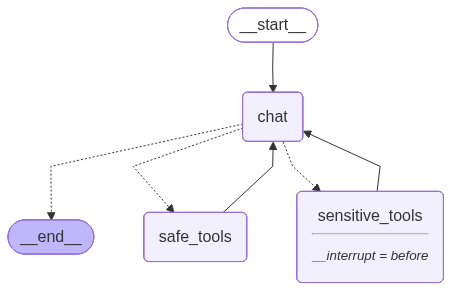

In [15]:
memory = MemorySaver()
compiled_graph = design_graph.compile(
    checkpointer=memory,
    # TODO: Make the graph interrupt before calling sensitive tools
    interrupt_before=["sensitive_tools"], 
)


try:
    from IPython.display import Image, display
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Mermaid rendering failed, trying ascii art")
    print(compiled_graph.get_graph().print_ascii())

### Putting user in the graph stream 

- If the graph's execution is interrupted, it's state will have the `next` parameter set to the name of the node the execution should continue on, once we invoke the graph again.

- During the interrupt, we ask for the user's approval for delete calls. If user says
    - **yes (y):** we just need to continue the graph's execution
    - **no (n):** we still need to append a `ToolMessage` with the correct tool_call_id to the `messages` key to satisfy the tool call.

In [16]:
def stream_graph_updates_with_interrupt(graph, user_input: str, config: dict, _printed: set):
    for event in graph.stream({"messages": [HumanMessage(content=user_input)]},
                              config, 
                              stream_mode="values"):
        _print_messages_from_stream_event(event, _printed)
    # After streaming, check for interrupt (pending sensitive tool execution)
    snapshot = graph.get_state(config)
    # TODO: Make sure the loop conditions gets triggered if the graph is interrupted
    while snapshot.next and snapshot.next[0] == "sensitive_tools": 
        # Ask user approval
        try:
            decision = input("Approve deletion tool call? ('y' to continue / or reason to deny): ")
        except Exception:
            decision = "y"
        if decision.strip().lower() == "y":
            # Continue execution (execute the sensitive tool)
            result = graph.invoke(None, config)
            _print_messages_from_state(result, _printed)
        else:
            # Deny: send ToolMessage with denial so model can adjust
            last_message = snapshot.values["messages"][-1]
            tool_call_id = last_message.tool_calls[0]["id"]
            # TODO: Invoke the graph with a new message in the graph state while satisfying the tool call ID requirement
            denial = graph.invoke({
                "messages": [
                    ToolMessage(
                        tool_call_id=tool_call_id,
                        content=f"Deletion denied by user. Reasoning: {decision} Continue without deleting and assist further."
                    )
                ]
            }, config)
            _print_messages_from_state(denial, _printed)
        snapshot = graph.get_state(config)


# Configure a new thread/session
config = {"configurable": {"thread_id": "rag_session_2"}}

# Track printed message ids to avoid duplicates on stream
_printed = set()

welcome_result = compiled_graph.invoke({"messages": [], "documents_to_chat": []}, config)
_print_messages_from_state(welcome_result, _printed)

# Interactive loop
while True:
    user_input = input("\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates_with_interrupt(compiled_graph, user_input, config, _printed)

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Welcome to the RAG System! I can help you:                                                                      │
│                                                                                                                 │
│ 📚 Document Management:                                                                                         │
│ - Embed (or update) YouTube videos or PDFs                                                                      │
│ - List stored documents (shows each document key)                                                               │
│ - Delete documents by key (will ask for confirmation)                                                           │
│                                                                                                                 │
│ 💬 Chat & Retrieval:                                                                                            │
│ - Ask questions about your selected documents                                                                   │
│ - Retrieve supporting chunks with sources (timestamps/pages)                                                    │
│                                                                                                                 │
│ Just tell me what you'd like to do!                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ whats embedded rn? Can you delete it?                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: list_documents                                                                                    │
│    Args: {}                                                                                                     │
│    ID: call_O0nN8fZKVFXKplDSsda4kHCS                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Documents in database:                                                                                          │
│                                                                                                                 │
│ 📄 1706.03762                                                                                                   │
│    key: 170603762 | chunks: 52 | added: 2025-09-22                                                              │
│                                                                                                                 │
│ Call ID: call_O0nN8fZKVFXKplDSsda4kHCS                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ Currently, there is one document embedded with the key "170603762" and it has 52 chunks. Would you like me to   │
│ delete this document? Please confirm.                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ yes                                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: delete_documents                                                                                  │
│    Args: {                                                                                                      │
│   "doc_keys": [                                                                                                 │
│     "170603762"                                                                                                 │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_4BjURfGvpwHeLebbbQluxRYz                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Deletion summary:                                                                                               │
│ Deleted:                                                                                                        │
│  - 1706.03762 (key: 170603762)                                                                                  │
│                                                                                                                 │
│ Call ID: call_4BjURfGvpwHeLebbbQluxRYz                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The document with key "170603762" has been deleted. If you want to embed new documents or have any other        │
│ requests, just let me know!                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ Can we embed https://arxiv.org/pdf/1706.03762?                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: embed_document                                                                                    │
│    Args: {                                                                                                      │
│   "source": "https://arxiv.org/pdf/1706.03762",                                                                 │
│   "doc_type": "pdf"                                                                                             │
│ }                                                                                                               │
│    ID: call_QWeB92Osi9iAgRtMJTVujjhl                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Embedded/Updated pdf: '1706.03762' (52 chunks) key=170603762                                                    │
│                                                                                                                 │
│ Call ID: call_QWeB92Osi9iAgRtMJTVujjhl                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The PDF from https://arxiv.org/pdf/1706.03762 has been embedded successfully with 52 chunks. You can now ask    │
│ questions about this document or request specific information.                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 👤 Human ────────────────────────────────────────────────────╮
│ Please embed /home/linus/Desktop/dreamer_v3_distilled.pdf                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: embed_document                                                                                    │
│    Args: {                                                                                                      │
│   "source": "/home/linus/Desktop/dreamer_v3_distilled.pdf",                                                     │
│   "doc_type": "pdf"                                                                                             │
│ }                                                                                                               │
│    ID: call_6s0CDJbYJtHOlHHaslMeqmii                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Embedded/Updated pdf: 'dreamer_v3_distilled' (41 chunks) key=dreamer_v3_distilled                               │
│                                                                                                                 │
│ Call ID: call_6s0CDJbYJtHOlHHaslMeqmii                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ The PDF located at /home/linus/Desktop/dreamer_v3_distilled.pdf has been embedded successfully with 41 chunks.  │
│ You can now ask questions about this document or the previously embedded one.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Goodbye!
